In [1]:
#%run -i '../../scripts/utility_readblt_ttTheoreticalUnc.py' 'mumu'

In [1]:
from utility_common import *
from utility_plotter import *
#import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
#plt.style.use('classic')

plt.rc("font",size=10)
plt.rc("savefig",dpi=300)
plt.rc("figure",facecolor="w",figsize=(6,4))

variable = {"ISR":"isr","FSR":"fsr","ME+PS":"hdamp","UE":""}

# 1. Plot kinematics

In [6]:
def makeAPlot(v,a,b,step,xl,selection,nbjetcut):
    pickledir  =  "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)
    if selection is "emu2":
        pickledir  =  "/mnt/data/zchen/Analysis/pickle/emu/"
    cuts = GetSelectionCut(selection) + "& (nBJets{})".format(nbjetcut)
    
    MCtt = pd.read_pickle(pickledir+"mctt/ntuple_ttbar_inclusive.pkl").query(cuts)



    mybins = np.arange(a,b,step)
    mybinscenter = mybins[0:-1]+step/2


    fig, axes = plt.subplots(2, 1, sharex=True, facecolor="w",
                             gridspec_kw={'height_ratios':[2,1]},
                             figsize=(6,6))
    fig.subplots_adjust(hspace=0)
    
    for iname,name in enumerate(["ISR","FSR","ME+PS","UE"]):

        ax = axes[0] 
        MCttdown = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}down.pkl".format(variable[name])).query(cuts)
        MCttup   = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}up.pkl".format(variable[name])).query(cuts)

        up0  = np.histogram(MCttup[v],  weights=MCttup  ["eventWeight"],bins=mybins)[0]
        down0= np.histogram(MCttdown[v],weights=MCttdown["eventWeight"],bins=mybins)[0]
        up = (up0+down0)/2+np.abs(up0-down0)/2
        down = (up0+down0)/2-np.abs(up0-down0)/2
        ax.bar(mybins[:-1]+step/2, up-down, step,bottom=down,color="C{}".format(iname),label=name,alpha=0.6)
        
        cent = ax.hist(MCtt[v],weights=MCtt["eventWeight"],bins=mybins,histtype="step",color='k',alpha=1,lw=2,label=None)[0]


        ax.legend(fontsize=14)
        ax.grid(True,linestyle="--",alpha=0.5)

        ax = axes[1]
        nonzero = cent>0
        downratio = down[nonzero]/(cent[nonzero])
        upratio = up[nonzero]/cent[nonzero]
        ax.fill_between(mybinscenter[nonzero],upratio,downratio,color="C{}".format(iname),alpha=0.6)
        #ax.plot(mybinscenter[nonzero],downratio,"-",color="c")
        #ax.plot(mybinscenter[nonzero],upratio,"-",color="purple")
    
    ax = axes[0]
    cent = ax.hist(MCtt[v],weights=MCtt["eventWeight"],bins=mybins,histtype="step",color='k',alpha=1,lw=2,label="nominal")[0]
    ax.legend(fontsize=14)
    
    ax = axes[1]
    ax.axhline(1,color="k")
    ax.set_ylim(0.6,1.4)
    ax.grid(True,linestyle="--",alpha=0.5)

    ax.set_xlabel(xl,fontsize=12)
    

In [7]:
def makePlot(selection,nbjetcut):
    if selection in ["e4j","mu4j"]:
        pp = pd.read_csv("plotparameters4j.csv")
    else:
        pp = pd.read_csv("plotparameters.csv")
    
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        makeAPlot(v,a,b,step,xl,selection,nbjetcut)
        
        plt.savefig("../../plot/{}/ttTheory/{}.png".format(selection,v),dpi=300)
        
        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()

In [8]:
for selection in ["emu","mumu","mutau","mu4j","ee","emu2","etau","e4j"]:
    makePlot(selection,">=1")

making plots nbjet>=1: 23/24



# 3. Plot yields


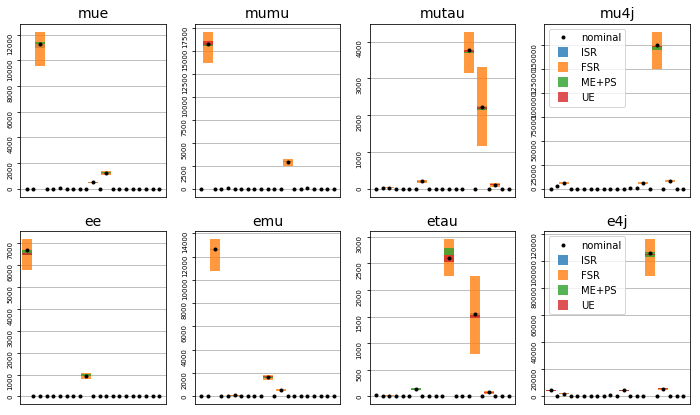

In [10]:
ctr = SelectionCounter()
plt.figure(figsize=(12,7))

x = np.arange(21)

for isel,selection in enumerate(["emu","mumu","mutau","mu4j","ee","emu2","etau","e4j"]):
    plt.subplot(2,4,isel+1)

    nbjetcut   = ">1"
    pickledir  =  "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)
    if selection is "emu2":
        pickledir  =  "/mnt/data/zchen/Analysis/pickle/emu/"
    cuts       = GetSelectionCut(selection) + "& (nBJets{})".format(nbjetcut)

    for name in ["ISR","FSR","ME+PS","UE"]:
        MCttdown = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}down.pkl".format(variable[name])).query(cuts)
        MCttup   = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}up.pkl".format(variable[name])).query(cuts)
        down = np.array(ctr.countSlt_ByTauDecay(MCttdown,withweights=True,withSF=True))
        up   = np.array(ctr.countSlt_ByTauDecay(MCttup,  withweights=True,withSF=True))
        plt.errorbar(x,(up+down)/2, yerr=np.abs(up-down)/2, fmt=' ',label=name,elinewidth=10,alpha=0.8)

    MCtt = pd.read_pickle(pickledir+"mctt/ntuple_ttbar_inclusive.pkl").query(cuts)
    cent = np.array(ctr.countSlt_ByTauDecay(MCtt,withweights=True,withSF=True))    
    plt.plot(x,cent,"k.",label="nominal")
    
    if isel in [3,7]:
        plt.legend()
    plt.title(selection,fontsize=14)
    if isel == 0:
        plt.title("mue",fontsize=14)
    if isel == 5:
        plt.title("emu",fontsize=14)
    
    plt.xticks([])
    plt.yticks(rotation=90,fontsize=7)
    plt.grid(True)

plt.savefig("../../plot/ttTheory/yields2b.png",dpi=300)
    


In [41]:
def plotUpAndDown(name,cent, colorUp="r",colorDown="b",mylinewidth="1",mylinestyle="-"):

    ax = axes[0] 
    MCttdown = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}down.pkl".format(variable[name])).query(cuts)
    MCttup   = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}up.pkl".format(variable[name])).query(cuts)
    up   = ax.hist( MCttup[v],weights=MCttup["eventWeight"],bins=mybins, 
                    histtype="step",color=colorUp,linestyle=mylinestyle,linewidth=mylinewidth,label=name+": up")

    down = ax.hist( MCttdown[v],weights=MCttdown["eventWeight"],bins=mybins,
                    histtype="step",color=colorDown,linestyle=mylinestyle,linewidth=mylinewidth,label=name+": down")

    ax.legend()
    ax = axes[1]
    down,up,cent = down[0],up[0],cent[0]
    nonzero = cent>0
    residualDown = (down[nonzero]-cent[nonzero])/cent[nonzero]**0.5
    residualUp   = (up  [nonzero]-cent[nonzero])/cent[nonzero]**0.5
    ax.plot(mybinscenter[nonzero],residualDown,mylinestyle,lw=mylinewidth,color=colorDown)
    ax.plot(mybinscenter[nonzero],residualUp, mylinestyle,lw=mylinewidth,color=colorUp)


Text(0.5,0,'lepton2_pt')

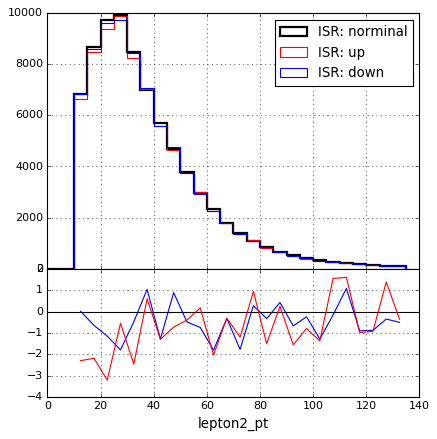

In [55]:
v,a,b,step,xl = "lepton2_pt",0,140,5,"lepton2_pt"

mybins = np.arange(a,b,step)
mybinscenter = mybins[0:-1]+step/2


fig, axes = plt.subplots(2, 1, sharex=True, facecolor="w",
                         gridspec_kw={'height_ratios':[2,1]},
                         figsize=(6,6))
fig.subplots_adjust(hspace=0)

ax = axes[0] 
cent = ax.hist(MCtt[v],weights=MCtt["eventWeight"],bins=mybins,
                histtype="step",color='k',alpha=1,lw=2,label=name+": norminal")
ax.grid(True)


ax = axes[1]
ax.axhline(0,color="k")
ax.grid(True)



colorUp="r"
colorDown="b"
mylinewidth="1"
mylinestyle="-"
ax = axes[0] 

MCttdown = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}down.pkl".format(variable[name])).query(cuts)
MCttup   = pd.read_pickle(pickledir+"mcttTheory/ntuple_ttbar_inclusive_{}up.pkl".format(variable[name])).query(cuts)
up   = ax.hist( MCttup[v],weights=MCttup["eventWeight"],bins=mybins, 
                histtype="step",color=colorUp,linestyle=mylinestyle,linewidth=mylinewidth,label=name+": up")

down = ax.hist( MCttdown[v],weights=MCttdown["eventWeight"],bins=mybins,
                histtype="step",color=colorDown,linestyle=mylinestyle,linewidth=mylinewidth,label=name+": down")

ax.legend()
ax = axes[1]
down,up,cent = down[0],up[0],cent[0]
nonzero = cent>0
residualDown = (down[nonzero]-cent[nonzero])/cent[nonzero]**0.5
residualUp   = (up  [nonzero]-cent[nonzero])/cent[nonzero]**0.5
ax.plot(mybinscenter[nonzero],residualDown,mylinestyle,lw=mylinewidth,color=colorDown)
ax.plot(mybinscenter[nonzero],residualUp, mylinestyle,lw=mylinewidth,color=colorUp)
    
# plotUpAndDown("FSR",cent,"purple","purple",2,"-")
# plotUpAndDown("ISR",cent,"r","r",2,"-")
# plotUpAndDown("UE",cent,"orange","orange",1,"-")
# plotUpAndDown("ME+PS",cent,"g","g",1,"-")


ax.set_xlabel(xl,fontsize=12)

In [4]:
pp = pd.read_csv("plotparameters.csv")
label_list = ['Diboson','V+Jets', r'$tt/tW \rightarrow l + had$',
              r'$tt/tW \rightarrow ll$ other',
              r'$tt/tW \rightarrow \mu + \mu$',
              r'$tt/tW \rightarrow \mu+ \tau$',
              'data']
color_list = ["#a32020", "#e0301e", "#eb8c00", "#49feec", "deepskyblue", "mediumpurple", "k"]

In [5]:
for nbjetcut in ["==1",">1",">=1"]:
    df_list,_,__ = prepare_df_list(nbjetcut)
    plotoutdir = GetPlotDir(selection, nbjetcut)
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        
        plotter = SelectionPlotter(v,a,b,step,df_list)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)

        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

finish all making plots


# 3. Counting

In [6]:
nbjetcut = "==1"
df_list,MCt,MCtt = prepare_df_list(nbjetcut)
ctr = SelectionCounter()

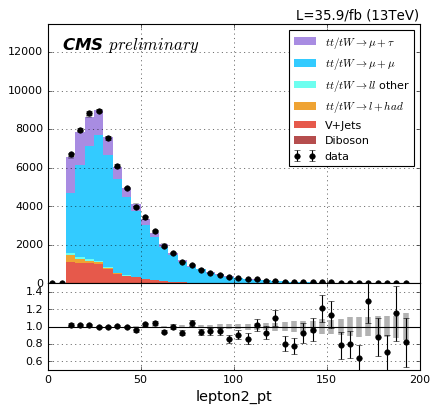

In [9]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton2_pt",0,200,5,"lepton2_pt"
plotter = SelectionPlotter(v,a,b,step,df_list)
plotter.settingPlot(xl,label_list,color_list,plotWithoutXsErr=False)
plotter.makePlot()

In [7]:
print("(nBJets{})".format(nbjetcut))
print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets==1)
MCtt: [0, 271460, 297, 0, 2155, 7, 0, 29, 0, 0, 23, 0, 52, 52112, 364, 0, 5139, 2, 406, 0, 3]
MCtt width: [0.0, 257460.0588704687, 250.81809615762904, 0.0, 1995.4688748016488, 4.893205776810646, 0.0, 27.554583817720413, 0.0, 0.0, 22.289065301418304, 0.0, 44.83300681016408, 48734.921078588464, 321.8788404385559, 0.0, 4550.211435906156, 2.2414177656173706, 354.1899142397742, 0.0, 2.5451186895370483]
MCt : [0, 1833, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 1, 372, 3, 0, 42, 0, 1, 0, 0]
MCt width: [0.0, 1763.500702716905, 0.0, 0.0, 12.329632185399532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5144170522689819, 354.26961600908544, 3.045598328113556, 0.0, 34.857424216810614, 0.0, 0.2623654305934906, 0.0, 0.0]


In [8]:
ctr.countSlt_Scaled(df_list)

data:70372.0
TotalMC:70359.28658751969
------ MC break down ------
[  187.35759304  7033.57110772   989.4197778    458.37285569
 51786.26053374  9904.30471954]


In [9]:
for thisdf in [df_list[0],df_list[1], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))

7033.57,73.81
989.42,15.44
2816.79,61.33
60321.56,108.49
70372.00,265.28


In [10]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 407605.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5158.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]
